In [45]:
import os
import cv2
import numpy as np
import math
import sys

import matplotlib.pyplot as plt
%matplotlib inline


################################
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

################################
import pandas 
# opencv coordinates: origin 0,0 is at top left corner
df = pandas.read_csv('muct76-opencv.csv', header=0, usecols=np.arange(2,154), dtype=float)

X = df.iloc[:, ::2].values
Y = df.iloc[:, 1::2].values

print(X.shape, Y.shape)

df.head()

################################
def draw_shape(img, points, color, closed=False):
    #print(points)
    imgout = img.copy()
    prev_point = points[0]
    for p in points[1:,:]:
        cv2.line(imgout, tuple(prev_point), tuple(p), 
                 color=color, thickness=2)
        prev_point = p
    if closed:
        cv2.line(imgout, tuple(prev_point), tuple(points[0,:]), 
                 color=color, thickness=2)
        
    return imgout

def genMask(src, tri):
    mask = np.zeros(src.shape, dtype = src.dtype)
    cv2.fillConvexPoly(mask, np.int32(tri), (1.0, 1.0, 1.0), 16, 0);
    return mask

(7510, 76) (7510, 76)


In [2]:
################################
# Apply affine transform calculated using srcTri and dstTri to src and
# output an image of size.
def applyAffineTransform(src, srcTri, dstTri, size) :
    
    # Given a pair of triangles, find the affine transform.
    warpMat = cv2.getAffineTransform( np.float32(srcTri), np.float32(dstTri) )
    
    #rbound = cv2.boundingRect(np.float32([dstTri]))
    #print(rbound)
    #size = (rbound[2], rbound[3])
    # Apply the Affine Transform just found to the src image
    dst = cv2.warpAffine( src, warpMat, (size[0], size[1]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101 )

    return dst

################################
# Warps and alpha blends triangular regions from img1 and img2 to img
def warpTriangle(img1, img2, t1, t2) :

    # Find bounding rectangle for each triangle
    r1 = cv2.boundingRect(np.float32([t1]))
    r2 = cv2.boundingRect(np.float32([t2]))

    # Offset points by left top corner of the respective rectangles
    t1Rect = [] 
    t2Rect = []
    t2RectInt = []

    for i in xrange(0, 3):
        t1Rect.append(((t1[i][0] - r1[0]),(t1[i][1] - r1[1])))
        t2Rect.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))
        t2RectInt.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))


    # Get mask by filling triangle
    mask = np.zeros((r2[3], r2[2], 3), dtype = np.float32)
    cv2.fillConvexPoly(mask, np.int32(t2RectInt), (1.0, 1.0, 1.0), 16, 0);

    # Apply warpImage to small rectangular patches
    img1Rect = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
    #img2Rect = np.zeros((r2[3], r2[2]), dtype = img1Rect.dtype)
    
    size = (r2[2], r2[3])

    img2Rect = applyAffineTransform(img1Rect, t1Rect, t2Rect, size)
    
    img2Rect = img2Rect * mask

    # Copy triangular region of the rectangular patch to the output image
    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = \
            img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] \
            * ( (1.0, 1.0, 1.0) - mask )
     
    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = \
            img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] + img2Rect 


################################
# Check if a point is inside a rectangle
def rectContains(rect, point) :
    if point[0] < rect[0] :
        return False
    elif point[1] < rect[1] :
        return False
    elif point[0] > rect[0] + rect[2] :
        return False
    elif point[1] > rect[1] + rect[3] :
        return False
    return True


#calculate delanauy triangle
def calculateDelaunayTriangles(rect, points):
    #create subdiv
    subdiv = cv2.Subdiv2D(rect);
    
    # Insert points into subdiv
    for p in points:
        subdiv.insert(p) 
    
    triangleList = subdiv.getTriangleList();
    
    delaunayTri = []
    
    pt = []    
    
    count= 0    
    
    for t in triangleList:        
        pt.append((t[0], t[1]))
        pt.append((t[2], t[3]))
        pt.append((t[4], t[5]))
        
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])        
        
        if rectContains(rect, pt1) and rectContains(rect, pt2) and rectContains(rect, pt3):
            count = count + 1 
            ind = []
            for j in range(0, 3):
                for k in range(0, len(points)):                    
                    if(abs(pt[j][0] - points[k][0]) < 1.0 and abs(pt[j][1] - points[k][1]) < 1.0):
                        ind.append(k)                            
            if len(ind) == 3:                                                
                delaunayTri.append((ind[0], ind[1], ind[2]))
        
        pt = []        
            
    
    return delaunayTri

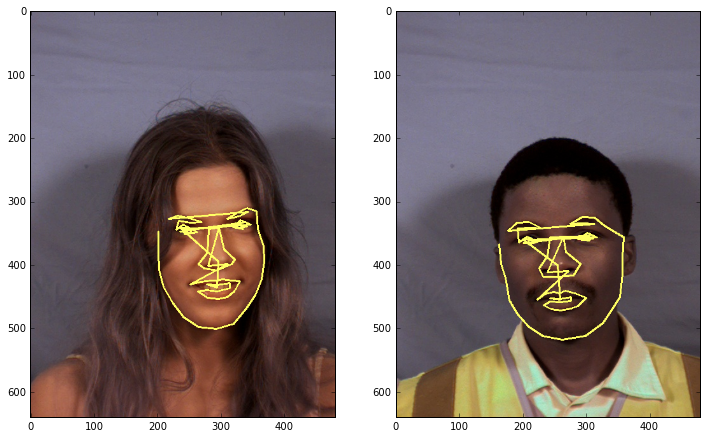

In [93]:

img1 = cv2.imread('figs/front-image.jpg')
img2 = cv2.imread('figs/front-image-2.jpg')

points1 = np.vstack ((X[0,:], Y[0,:])).T    # i000qa-fn
points2 = np.vstack ((X[15,:], Y[15,:])).T  # i001qa-mn

points1 = points1.astype(int)
points2 = points2.astype(int)

### Plot
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
img1shape = draw_shape(img1, points1[:,:], color=(100,255,255))
plt.imshow(cv2.cvtColor(img1shape, cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
img2shape = draw_shape(img2, points2[:,:], color=(100,255,255))
plt.imshow(cv2.cvtColor(img2shape, cv2.COLOR_BGR2RGB))
plt.show()

(18, 2)
(17, 2)


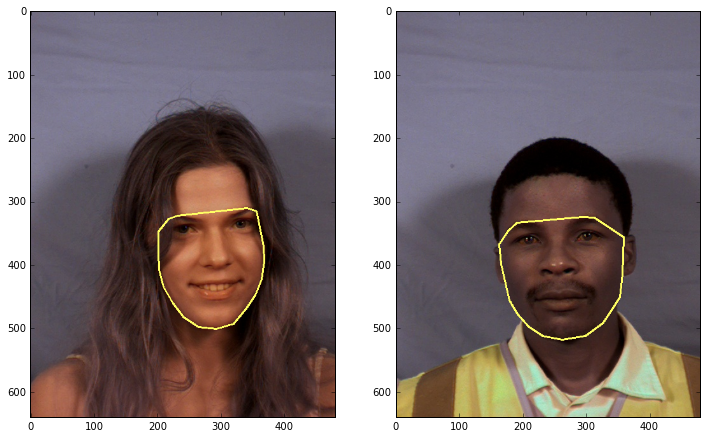

In [4]:
hull1 = []
hull2 = []

hullIndex1 = cv2.convexHull(np.array(points1), returnPoints = False)
hullIndex2 = cv2.convexHull(np.array(points2), returnPoints = False)

for i in range(0, len(hullIndex1)):
    hull1.append(tuple(points1[hullIndex1.flatten()[i]]))

for i in range(0, len(hullIndex2)):
    hull2.append(tuple(points2[hullIndex2.flatten()[i]]))

hull1arr = np.array(hull1)
hull2arr = np.array(hull2)

print(hull1arr.shape)
print(hull2arr.shape)

### Plot
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
img1shape = draw_shape(img1, hull1arr, color=(100,255,255), closed=True)
plt.imshow(cv2.cvtColor(img1shape, cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
img2shape = draw_shape(img2, hull2arr, color=(100,255,255), closed=True)
plt.imshow(cv2.cvtColor(img2shape, cv2.COLOR_BGR2RGB))
plt.show()

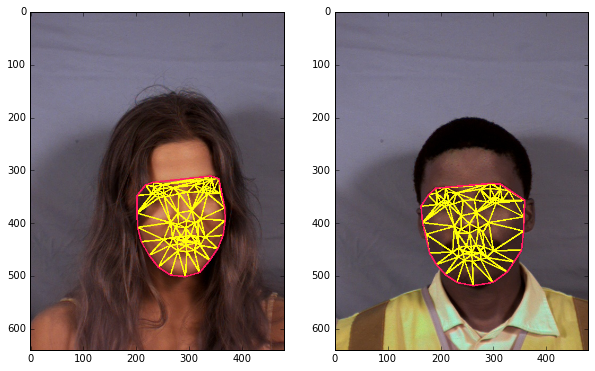

In [5]:
sizeImg1 = img1.shape    
rect = (0, 0, sizeImg1[1], sizeImg1[0])

trilist = calculateDelaunayTriangles(rect, tuple(map(tuple, points1)))

tmp1 = img1.copy()
tmp2 = img2.copy()


for tri in trilist:
    tp1 = points1[tri, :]
    tp2 = points2[tri, :]
    tmp1 = draw_shape(tmp1, tp1, (10,255,255), True)
    tmp2 = draw_shape(tmp2, tp2, (10,255,255), True)
    
tmp1 = draw_shape(tmp1, hull1arr, color=(100,25,255), closed=True)
tmp2 = draw_shape(tmp2, hull2arr, color=(100,25,255), closed=True)

plt.figure(figsize=(10,16))
plt.subplot(1,2, 1)
plt.imshow(cv2.cvtColor(tmp1, cv2.COLOR_BGR2RGB))
plt.subplot(1,2, 2)
plt.imshow(cv2.cvtColor(tmp2, cv2.COLOR_BGR2RGB))
plt.show()

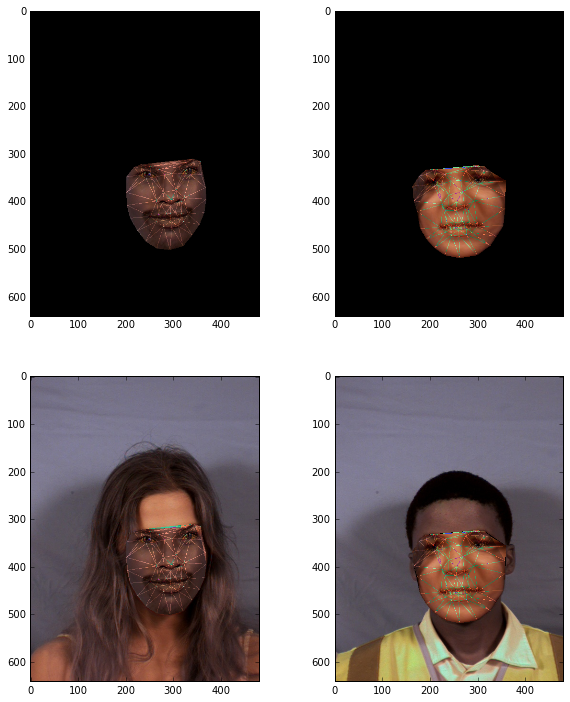

In [66]:
face1on2 = np.zeros(shape=img2.shape, dtype=img2.dtype)
face2on1 = np.zeros(shape=img1.shape, dtype=img1.dtype)

tmp1 = img1.copy()
tmp2 = img2.copy()

for tri in trilist:
    tp1 = points1[np.array(tri),:]
    tp2 = points2[np.array(tri),:]
    
    res1 = applyAffineTransform(img1, tp1, tp2, (img2.shape[1], img2.shape[0]))
    tri_mask1 = genMask(res1, tp2)
    face1on2 += res1 * 
    
    res2 = applyAffineTransform(img2, tp2, tp1, (img1.shape[1], img1.shape[0]))
    face2on1 += res2 * genMask(res2, tp1)
    
mask1 = np.array((1,1,1), dtype=img1.dtype) - genMask(img1, hull1)
mask2 = np.array((1,1,1), dtype=img2.dtype) - genMask(img2, hull2)

plt.figure(figsize=(10,12))
plt.subplot(2,2, 1)
plt.imshow(cv2.cvtColor(face2on1 , cv2.COLOR_BGR2RGB))
plt.subplot(2,2, 2)
plt.imshow(cv2.cvtColor(face1on2, cv2.COLOR_BGR2RGB))
plt.subplot(2,2, 3)
g = np.uint8(np.tile([1.0], mask1.shape) - mask1)

plt.imshow(cv2.cvtColor(img1*mask1 + face2on1 , cv2.COLOR_BGR2RGB))
plt.subplot(2,2, 4)
plt.imshow(cv2.cvtColor(img2*mask2 + face1on2, cv2.COLOR_BGR2RGB))
plt.show()

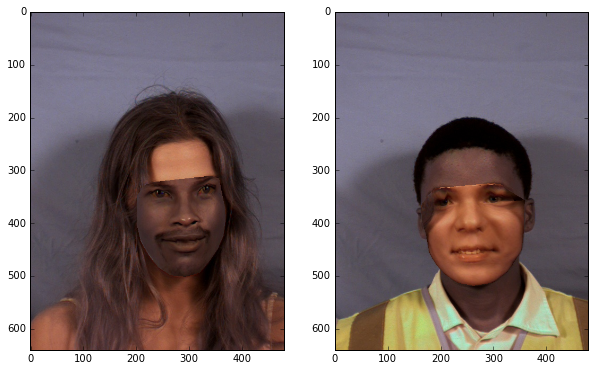

In [104]:
def warpTriangle(img1, img2, t1, t2):
    """ Warping triangular patch from image 1 onto image 2
    """
    
    r1 = cv2.boundingRect(np.float32([t1]))
    r2 = cv2.boundingRect(np.float32([t2]))
    
    t1_local, t2_local = [], []
    for i in range(3):
        t1_local.append(((t1[i][0] - r1[0]), t1[i][1] - r1[1]))
        t2_local.append(((t2[i][0] - r2[0]), t2[i][1] - r2[1]))
        
    #mask1 = np.zeros((r1[3], r1[2], 3), dtype = np.float32)
    mask_t2 = np.zeros((r2[3], r2[2], 3), dtype = np.float32)
    #cv2.fillConvexPoly(mask1, np.int32(t1_local), (1.0, 1.0, 1.0), 16, 0)
    cv2.fillConvexPoly(mask_t2, np.int32(t2_local), (1.0, 1.0, 1.0), 16, 0)
    
    x1left, x1right, y1left, y1right = r1[1], r1[1]+r1[3], r1[0], r1[0]+r1[2]
    x2left, x2right, y2left, y2right = r2[1], r2[1]+r2[3], r2[0], r2[0]+r2[2]
    
    img1_patch = img1[x1left:x1right, y1left:y1right]
    img2_patch = img2[x2left:x2right, y2left:y2right]
    
    img1_patch_warped = applyAffineTransform(img1_patch, t1_local, t2_local, (r2[2], r2[3]))
    #img2_patch_warped = applyAffineTransform(img2_patch, t2_local, t1_local, (r1[2], r1[3]))
    #print(mask2.shape, img1_patch.shape, img1_patch_warped.shape)
    img1_patch_warped = img1_patch_warped * mask_t2
    #img2_patch_warped = img2_patch_warped * mask1
    
    #out1[x1left:x1right, y1left:y1right] = img1_patch * ( (1.0, 1.0, 1.0) - mask1)
    img2[x2left:x2right, y2left:y2right] = img2_patch * ( (1.0, 1.0, 1.0) - mask_t2)
    
    #out1[x1left:x1right, y1left:y1right] = img1_patch + img2_patch_warped
    img2[x2left:x2right, y2left:y2right] = img2_patch + img1_patch_warped
    
    #return (out1, out2)
        
    
res1 = img1.copy()
res2 = img2.copy()
for tri in trilist:
    tp1 = points1[np.array(tri),:]
    tp2 = points2[np.array(tri),:]
    warpTriangle(img1, res2, tp1, tp2)
    warpTriangle(img2, res1, tp2, tp1)

    
plt.figure(figsize=(10,12))
plt.subplot(1,2, 1)
plt.imshow(cv2.cvtColor(res1 , cv2.COLOR_BGR2RGB))
plt.subplot(1,2, 2)
plt.imshow(cv2.cvtColor(res2, cv2.COLOR_BGR2RGB))
plt.show()

((357, 344), (367, 395), (363, 423), (353, 448), (338, 470), (319, 493), (292, 501), (264, 498), (241, 483), (224, 461), (209, 435), (201, 381), (201, 348), (217, 328), (231, 323), (325, 318), (340, 311))
((358, 357), (356, 415), (352, 451), (338, 473), (325, 492), (298, 512), (261, 518), (230, 512), (208, 497), (191, 478), (178, 456), (165, 399), (162, 368), (176, 347), (190, 334), (293, 325), (312, 326))


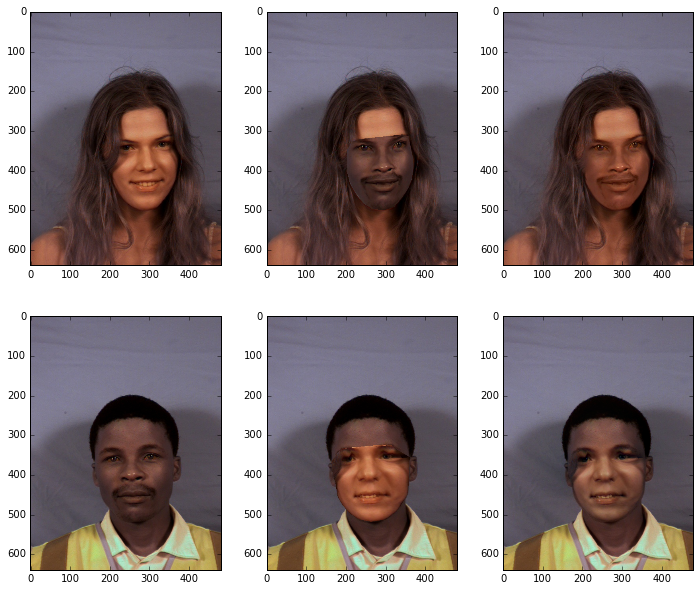

In [114]:
def CloneSeamless(obj, srcimg, hullpoints):
    mask = np.zeros(obj.shape, dtype = obj.dtype) 
    
    hull = tuple(map(tuple, hullpoints))
    cv2.fillConvexPoly(mask, np.int32(hull), (255, 255, 255))
    print(hull)
    r = cv2.boundingRect(np.float32([hullpoints]))    
    
    center = ((r[0]+int(r[2]/2), r[1]+int(r[3]/2)))
    output = cv2.seamlessClone(np.uint8(obj), srcimg, mask, center, cv2.NORMAL_CLONE)
    
    return output
    
out1 = CloneSeamless(res1, img1, hull1)
out2 = CloneSeamless(res2, img2, hull2)

plt.figure(figsize=(12,10))
plt.subplot(2,3, 1)
plt.imshow(cv2.cvtColor(img1 , cv2.COLOR_BGR2RGB))
plt.subplot(2,3, 2)
plt.imshow(cv2.cvtColor(res1 , cv2.COLOR_BGR2RGB))
plt.subplot(2,3, 3)
plt.imshow(cv2.cvtColor(out1, cv2.COLOR_BGR2RGB))
plt.subplot(2,3, 4)
plt.imshow(cv2.cvtColor(img2 , cv2.COLOR_BGR2RGB))
plt.subplot(2,3, 5)
plt.imshow(cv2.cvtColor(res2 , cv2.COLOR_BGR2RGB))
plt.subplot(2,3, 6)
plt.imshow(cv2.cvtColor(out2, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
face1on2 = np.zeros(shape=img2.shape, dtype=img2.dtype)
face2on1 = np.zeros(shape=img1.shape, dtype=img1.dtype)

tmp1 = img1.copy()
tmp2 = img2.copy()

for tri in trilist:
    tp1 = points1[np.array(tri),:]
    tp2 = points2[np.array(tri),:]
    
    res1 = applyAffineTransform(img1, tp1, tp2, (img2.shape[1], img2.shape[0]))
    tri_mask1 = genMask(res1, tp2)
    face1on2 += res1 * 
    
    res2 = applyAffineTransform(img2, tp2, tp1, (img1.shape[1], img1.shape[0]))
    face2on1 += res2 * genMask(res2, tp1)
    
mask1 = np.array((1,1,1), dtype=img1.dtype) - genMask(img1, hull1)
mask2 = np.array((1,1,1), dtype=img2.dtype) - genMask(img2, hull2)


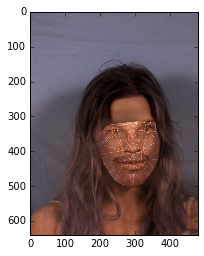

In [31]:
center1 = tuple(np.mean(points1, axis=0).astype(int))
center2 = tuple(np.mean(points2, axis=0).astype(int))

r1 = cv2.boundingRect(np.float32([points1]))

f21 = face2on1[r1[1]:r1[1]+r1[3], r1[0]:r1[0]+r1[2]]
mask = 255* np.ones(shape=f21.shape, dtype=img1.dtype)
mask.shape
center = ((r1[0]+int(r1[2]/2), r1[1]+int(r1[3]/2)))
output = cv2.seamlessClone(f21, img1, mask, center, cv2.NORMAL_CLONE)

plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.show()

In [23]:
hullIndex = cv2.convexHull(np.array(points2), returnPoints = False)

hull1, hull2 = [], []

for i in range(0, len(hullIndex)):
    hull1.append(points1[hullIndex[i]][0])
    hull2.append(points2[hullIndex[i]][0])
    
#print(hull2[3])
hull8U = []
for i in range(0, len(hull2)):
    hull8U.append((hull2[i][0], hull2[i][1]))


mask = np.zeros(img2.shape, dtype = img2.dtype)  
    
cv2.fillConvexPoly(mask, np.int32(hull8U), (255, 255, 255))
mask.dtype

dtype('uint8')

# 

In [43]:
(1,1,1) - mask1

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ..., 
       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]])

In [ ]:
    r1 = cv2.boundingRect(np.float32([tp1]))
    r2 = cv2.boundingRect(np.float32([tp2]))
    
    tp1R1 = [] 
    tp2R2 = []
    for i in range(0, 3):
        tp1R1.append(((tp1[i][0] - r1[0]),(tp1[i][1] - r1[1])))
        tp2R2.append(((tp2[i][0] - r2[0]),(tp2[i][1] - r2[1])))

    img1R1 = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
    img2R2 = img2[r2[1]:r2[1] + r2[3], r2[0]:r2[0] + r2[2]]
    
    res1 = applyAffineTransform(img1R1, tp1R1, tp2R2, (r2[2], r2[3]))
    mask = np.zeros((r2[3], r2[2], 3), dtype = np.float32)
    cv2.fillConvexPoly(mask, np.int32(tp2R2), (1.0, 1.0, 1.0), 16, 0)
    face1on2 += res1 * mask

In [58]:
np.tile([1,1,1], (3, 2))

array([[1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1]])